# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import signal
# import math
# import os
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
import seaborn as sn

from sklearn.preprocessing import StandardScaler
import shap

from tradnet import *

## Set Inputs

In [2]:
seed = 7
n_samples = 10000
num_metaims = 5             # NOTE: Here this variable denotes the number of Intensity Measures to use

In [3]:
path_to_predictor_dataset = 'predictors_new.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_pga_dataset = '../../RC_Frame_large/pga_all_new.parquet'

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'drift_ratio_pct_max', 'damage_state']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')
# predictors_all = predictors_all[predictors_all['tip_displacement']<48].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

In [5]:
pga_all = pd.read_parquet(path_to_pga_dataset, engine = 'pyarrow')
predictors_all = predictors_all.merge(pga_all[['sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa150', 'sa20', 'arias', 'sed', 'cav', 'ASI_05', 'ASI_10']], 
                                      left_on = 'gm_index', right_index = True)

We assume the collapse capacity of the building to be 12 inches

In [6]:
# # capacity = predictors_all['tip_displacement'].quantile(0.95)
# capacity = 24
# predictors_all['capacity'] = capacity
# predictors_all['damage_state'] = 0

# predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

# predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Prepare training data

In [7]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['damage_state']

cols_gm = ['pga', 'pgv', 'arias', 'cav', 'ASI_05']
# cols_gm = ['pga', 'pgv', 'sa06', 'sa150', 'arias']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa03', 'sa10']


# cols_gm = ['pga', 'pgv', 'cav', 'sa01', 'sa02', 'ASI_05', 'ASI_10', 'arias']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa02', 'sa03', 'sa06', 'sa10']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa03', 'sa10']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa03']
# cols_gm = ['pga', 'pgv', 'sa01']
# cols_gm = ['pga', 'pgv']
# cols_gm = ['pga']

x_data, x_val, x_test, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                            val_data, 
                                                                            test_data, 
                                                                            cols2scale, 
                                                                            cols_gm)


In [8]:
len(train_data['gm_index'].unique())

7714

## Train TradNet Model

In [9]:
max_epochs = 5000
interval = 50

start = timeit.default_timer()
model, error_evolution_training, error_evolution_val = train_tradnet_model(x_data, 
                                                                      x_val, 
                                                                      y_data, 
                                                                      y_val, 
                                                                      train_data, 
                                                                      val_data,
                                                                      max_epochs = max_epochs,
                                                                      automate_stopping = False,
                                                                      interval = interval,
                                                                      alpha = 1e-3,
                                                                      nlayers = 4,
                                                                      nhidden = 24)
stop = timeit.default_timer()

Epoch 1: Training BCE Loss 0.8348, Validation BCE Loss 0.8320
Epoch 50: Training BCE Loss 0.6194, Validation BCE Loss 0.6249
Epoch 100: Training BCE Loss 0.5716, Validation BCE Loss 0.5796
Epoch 150: Training BCE Loss 0.5567, Validation BCE Loss 0.5648
Epoch 200: Training BCE Loss 0.5442, Validation BCE Loss 0.5538
Epoch 250: Training BCE Loss 0.5317, Validation BCE Loss 0.5453
Epoch 300: Training BCE Loss 0.5242, Validation BCE Loss 0.5428
Epoch 350: Training BCE Loss 0.5177, Validation BCE Loss 0.5412
Epoch 400: Training BCE Loss 0.5137, Validation BCE Loss 0.5409
Epoch 450: Training BCE Loss 0.5112, Validation BCE Loss 0.5410
Epoch 500: Training BCE Loss 0.5095, Validation BCE Loss 0.5397
Epoch 550: Training BCE Loss 0.5078, Validation BCE Loss 0.5394
Epoch 600: Training BCE Loss 0.5063, Validation BCE Loss 0.5383
Epoch 650: Training BCE Loss 0.5048, Validation BCE Loss 0.5376
Epoch 700: Training BCE Loss 0.5035, Validation BCE Loss 0.5362
Epoch 750: Training BCE Loss 0.5020, Valida

In [10]:
print('Time Elapsed in Model Training: ', stop - start)

Time Elapsed in Model Training:  32.5556555557996


In [11]:
y_pred_val = predict_tradnet(model, x_val)
val_data['damage_state_pred'] = y_pred_val.detach().view(-1).numpy()
val_data['damage_state_class_pred'] = val_data['damage_state_pred'].round().astype("int")

y_pred_train = predict_tradnet(model, x_data)
train_data['damage_state_pred'] = y_pred_train.detach().view(-1).numpy()
train_data['damage_state_class_pred'] = train_data['damage_state_pred'].round().astype("int")

## Distribution of Responses

,Survived,Failed
Survived,0.900533,0.099467
Failed,0.091533,0.908467


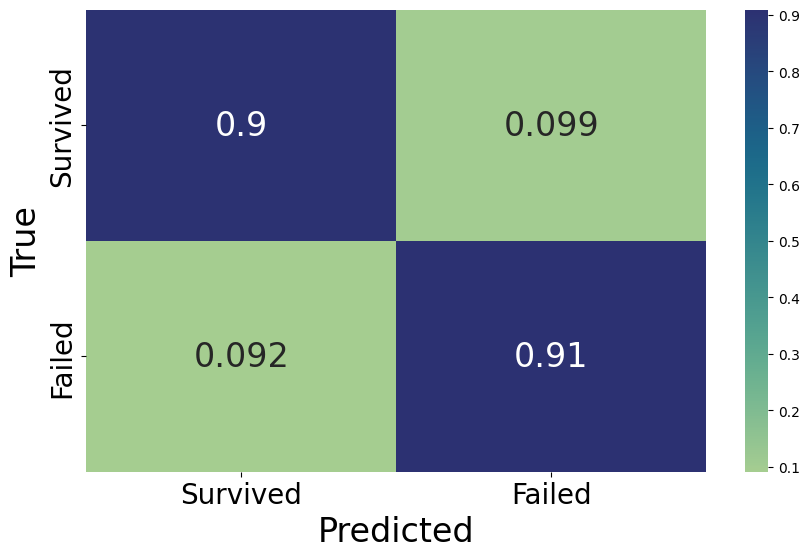

In [12]:
# constant for classes
classes = ('Survived', 'Failed')
plot_confusion(val_data, 'damage_state', 'damage_state_class_pred', classes)

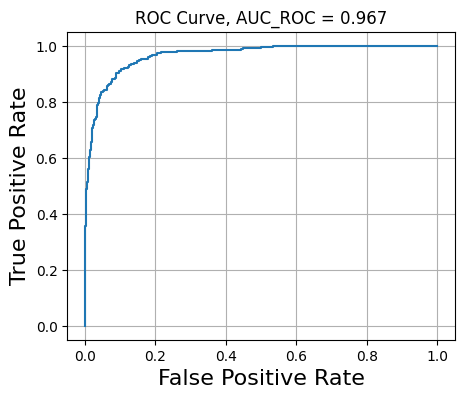

In [13]:
plot_auc_roc(val_data, 'damage_state', 'damage_state_pred')

,Survived,Failed
Survived,0.918956,0.081044
Failed,0.056331,0.943669


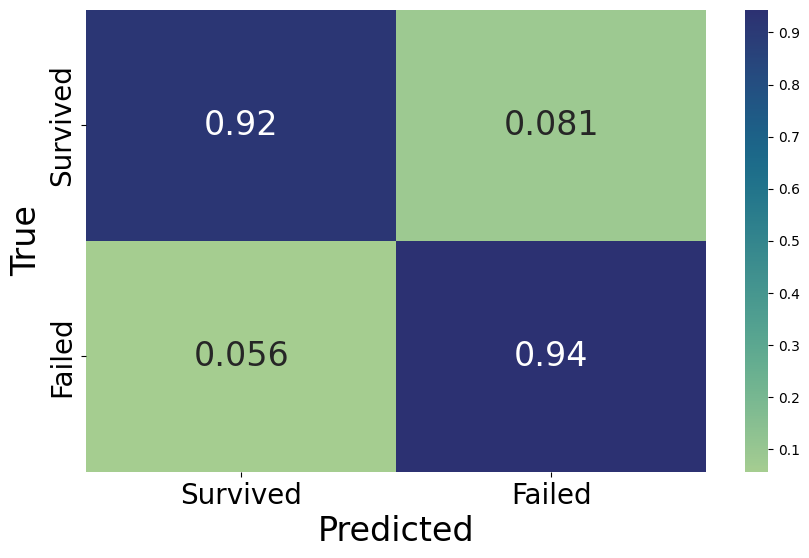

In [14]:
plot_confusion(train_data, 'damage_state', 'damage_state_class_pred', classes)

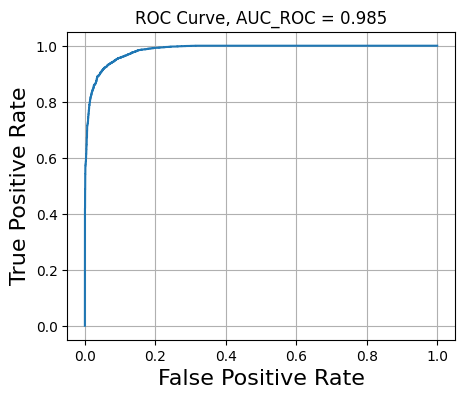

In [15]:
plot_auc_roc(train_data, 'damage_state', 'damage_state_pred')

## Loss Evolution

In [16]:
window_size = interval
epoch_count = np.array(range(window_size, len(error_evolution_training) + 1))
error_evolution_training = np.array(error_evolution_training)
error_evolution_training = np.convolve(error_evolution_training, 
                                       np.ones(window_size)/window_size, mode='valid')
error_evolution_val = np.array(error_evolution_val)
error_evolution_val = np.convolve(error_evolution_val, 
                                       np.ones(window_size)/window_size, mode='valid')

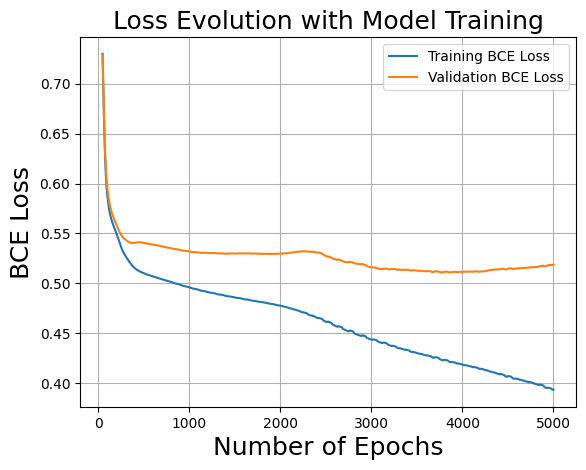

In [17]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(epoch_count, error_evolution_training, label = 'Training BCE Loss')
ax.plot(epoch_count, error_evolution_val, label = 'Validation BCE Loss')
# ax.plot(range(len(error_evolution_training)), error_evolution_training, label = 'Training BCE Loss')
# ax.plot(range(len(error_evolution_val)), error_evolution_val, label = 'Validation BCE Loss')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("BCE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [18]:
y_pred_test = predict_tradnet(model, x_test)
test_data['damage_state_pred'] = y_pred_test.detach().view(-1).numpy()
test_data['damage_state_class_pred'] = test_data['damage_state_pred'].round().astype("int")

## Confusion Matrix on Test Data

,Survived,Failed
Survived,0.896955,0.103045
Failed,0.088825,0.911175


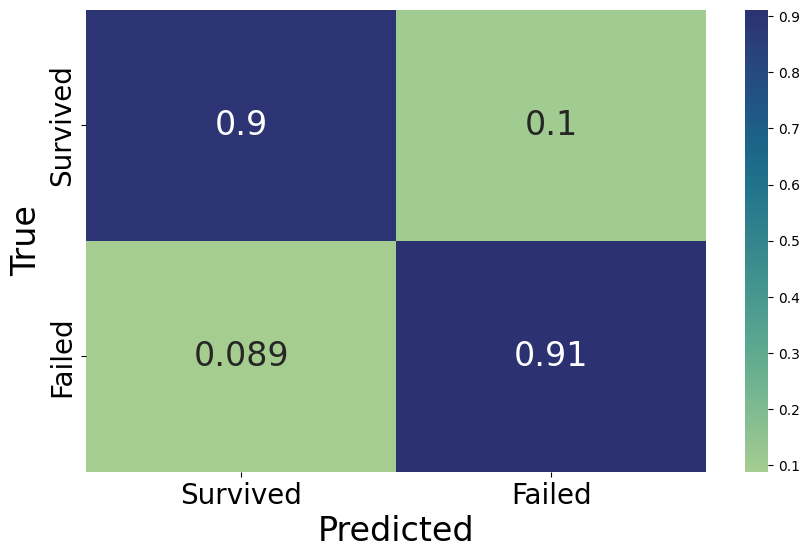

In [19]:
plot_confusion(test_data, 'damage_state', 'damage_state_class_pred', classes)

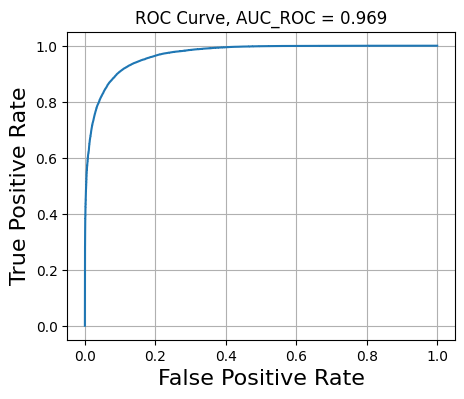

In [20]:
plot_auc_roc(test_data, 'damage_state', 'damage_state_pred')

In [21]:
accuracy_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9031342722761373

In [22]:
roc_auc_score(np.array(test_data['damage_state']), np.array(test_data['damage_state_pred']))

0.969104861818333

In [23]:
precision_score((test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.8717195344591511

In [24]:
recall_score((test_data['damage_state']), np.array(test_data['damage_state_class_pred']))

0.9111753831474745

## Confusion Matrix on Combined Train, Validation, and Test Data

,Survived,Failed
Survived,0.899255,0.100745
Failed,0.085478,0.914522


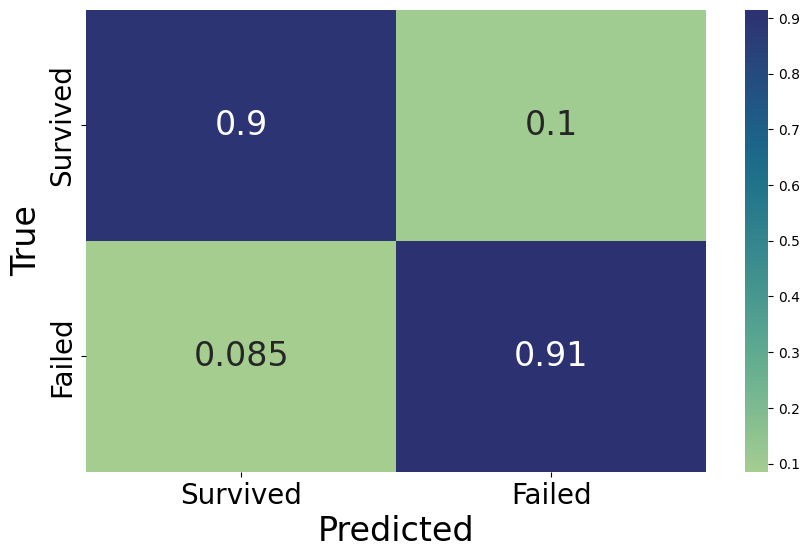

In [25]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_confusion(all_data, 'damage_state', 'damage_state_class_pred', classes)

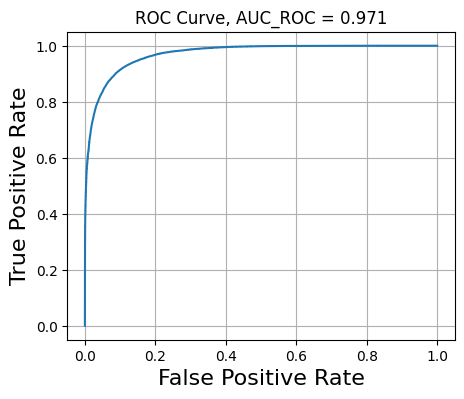

In [26]:
plot_auc_roc(all_data, 'damage_state', 'damage_state_pred')

## Compare Fragilities

In [27]:
fragility_df_gt = develop_fragility_model_stripe(all_data, 'pga', 'damage_state', bin_width = 0.1, 
                                                 max_im = 1.5, mu = 0.80, beta = 1.2)
fragility_df_pred = develop_fragility_model_stripe(all_data, 'pga', 'damage_state_class_pred', bin_width = 0.1, 
                                                   max_im = 1.5, mu = 0.80, beta = 1.2)

In [28]:
fragility_df_gt

,IM,Probability
0,0.05,0.000125
1,0.15,0.050256
2,0.25,0.172881
3,0.35,0.318418
4,0.45,0.429886
5,0.55,0.512287
6,0.65,0.564525
7,0.75,0.599796
8,0.85,0.64117
9,0.95,0.671461


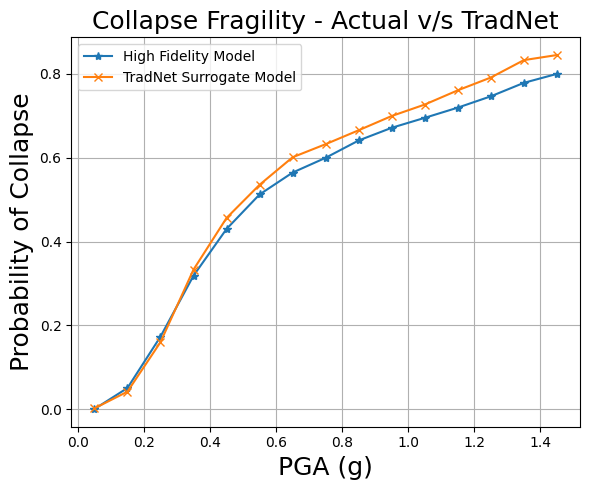

 Mean error = 0.031792, Max error = 0.054236


In [29]:
fig, ax = plt.subplots(1,1, figsize = (6, 5))

error_mean = (((fragility_df_gt['Probability'] - fragility_df_pred['Probability'])**2).mean())**0.5
error_max = (((fragility_df_gt['Probability'] - fragility_df_pred['Probability'])**2).max())**0.5

ax.plot(np.array(fragility_df_gt['IM']), np.array(fragility_df_gt['Probability']), '*-', label = 'High Fidelity Model')
ax.plot(np.array(fragility_df_pred['IM']), np.array(fragility_df_pred['Probability']), 'x-', label = 'TradNet Surrogate Model')
ax.legend()
ax.set_xlabel('PGA (g)', fontsize = 18)
ax.set_ylabel('Probability of Collapse', fontsize = 18)
ax.set_title('Collapse Fragility - Actual v/s TradNet', fontsize = 18)
ax.grid()

plt.tight_layout()
plt.show()

print(' Mean error = {}, Max error = {}'.format(round(error_mean,6), round(error_max,6)))

In [30]:
all_data_high = all_data[all_data['pga']>1.0]
precision_score(np.array(all_data_high['damage_state']), 
               np.array(all_data_high['damage_state_class_pred']))

0.915168806466952

In [31]:
recall_score(np.array(all_data_high['damage_state']), 
               np.array(all_data_high['damage_state_class_pred']))

0.9680112664721859

In [32]:
# fragility_df_pred.to_parquet('frag_df{}_tradnet_{}.parquet'.format(len(cols_gm), seed), engine = 'pyarrow')

## Further Analysis

In [33]:
# Predict using the trained model
# meta_im_cols = ['meta_im_{}'.format(i) for i in range(num_metaims)]
x_th = torch.tensor(all_data[cols_gm].values)

x_to_scale_train = torch.tensor(train_data[cols2scale].values)
scaler = StandardScaler()
scaler.fit(x_to_scale_train)

x_to_scale = torch.tensor(all_data[cols2scale].values)
x_scaled = torch.tensor(scaler.transform(x_to_scale))

x_data_all = torch.cat((x_th, x_scaled), dim = 1)

def predict_shap(x_data_all):
    x_data_all = torch.tensor(x_data_all)
    y_pred = model(x_data_all.float()).detach().numpy()
    
    return y_pred

In [34]:
shap.initjs()

In [35]:
x_data_sampled = x_data_all[np.random.choice(x_data_all.shape[0], size=100, replace=False)]

explainer = shap.KernelExplainer(predict_shap, np.array(x_data_sampled))
shap_values = explainer.shap_values(np.array(x_data_all)[:100])

/tmp/ipykernel_33771/1224263656.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  explainer = shap.KernelExplainer(predict_shap, np.array(x_data_sampled))
/tmp/ipykernel_33771/1224263656.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  shap_values = explainer.shap_values(np.array(x_data_all)[:100])


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_33771/3852661204.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(x_data_all)[:100],


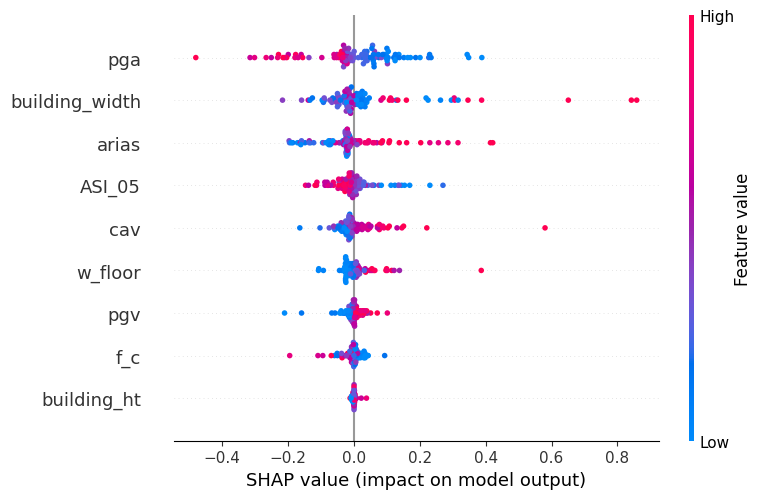

In [36]:
feature_names = cols2scale + cols_gm

shap.summary_plot(shap_values.squeeze(-1), 
                  np.array(x_data_all)[:100], 
                  feature_names=feature_names)

In [37]:
# shap_values = explainer.shap_values(np.array(x_data_all)[-1000:])

# shap.summary_plot(shap_values.squeeze(-1), 
#                   np.array(x_data_all)[-1000:], 
#                   feature_names=feature_names)

In [38]:
# shap_values = explainer.shap_values(np.array(x_data_all)[-10000:])

# shap.summary_plot(shap_values.squeeze(-1), 
#                   np.array(x_data_all)[-10000:], 
#                   feature_names=feature_names)

In [39]:
# shap_values = explainer.shap_values(np.array(x_data_all)[10000:])

# shap.summary_plot(shap_values.squeeze(-1), 
#                   np.array(x_data_all)[10000:], 
#                   feature_names=feature_names)

In [40]:
# import pickle

# # Example: model and scaler
# model_path = "tradnet_5.pkl"

# save_dict = {
#     'model_state_dict': model.state_dict(),
#     'scaler': scaler,  # e.g., StandardScaler from sklearn
#     'im_list': cols_gm,  # optional: to recreate the model
#     'random_seed': seed,         # optional: seed used, needed to split the dataset
# }

# # Save using pickle
# with open(model_path, 'wb') as f:
#     pickle.dump(save_dict, f)